# UM Validation

In [1]:
%load_ext watermark
%watermark -u -d -m -v -p numpy,matplotlib,iris,sattools,umtools,faamtools,pyveccalc

last updated: 2016-09-19 

CPython 3.5.2
IPython 5.1.0

numpy 1.10.4
matplotlib 1.5.3
iris 1.10.0
sattools 0.1
umtools 0.1.5
faamtools 0.2.3
pyveccalc 0.2.8

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 3.13.0-95-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit


In [2]:
%matplotlib inline

In [3]:
import datetime
import iris
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import numpy as np
import os
import string
#
from faamtools.core import parse_profiles_runs_info, read_core_nc
from faamtools.cloud import read_cdp_nc, read_nevzorov_nc, read_cloud_hdf
import umtools.irismode as umi
import umtools.utils as umu
#
import mypaths
import mpl_func as mympl
import plot_params as pp
import phys_meteo as met

In [4]:
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.family'] = 'sans-serif'

In [5]:
fmt = 'pdf'
svfigkw = dict(dpi=300, bbox_inches='tight', format=fmt)

## Airborne data

In [6]:
filt_keys = dict(sample_rate=1., cutoff=1/50., order=6)

### Core instruments

In [7]:
fl_seg = parse_profiles_runs_info(os.path.join(mypaths.faamdir,'sawtooth_summary.txt'), daystr='20130326')

In [8]:
flds = dict(time='Time',lon='LON_GPS',lat='LAT_GPS',hgt='HGT_RADR', hgt_gps='GPS_ALT', ang='TRCK_GIN',
            lwc_jw='LWC_JW_U', twc_evap='TWC_EVAP', twc_lyman='TWC_DET', tdew_ge='TDEW_GE',
            u='U_NOTURB', v='V_NOTURB', wturb='W_C',
            swdown='SW_DN_C', swup='SW_UP_C', pres='PS_RVSM', t_di='TAT_DI_R', t_nd='TAT_ND_R', btheim_c='BTHEIM_C')

# Input files
faam = read_core_nc(mypaths.faamf, flds, time2datetime=True)

In [9]:
air_density = faam.pres.val*1e2/(met.Rd*faam.t_di.val) # Air density in (kg m-3)

In [10]:
good = np.where((~np.isnan(faam.lon.val)) & (~np.isnan(faam.lat.val)) \
              & (faam.lat.val > 72.))[0]

### Cloud data

#### Nevzorov

In [11]:
nevz_time, nevz_twc_liq, nevz_twc_ice, nevz_lwc_liq, nevz_lwc_ice = read_nevzorov_nc(os.path.join(mypaths.cloud_data_dir,'b763_nevzorov_20130326_1hz_r1.nc'),
                                                                                    tbase=datetime.datetime(2013,3,26), tstep_sec=1)
it1_nevz = np.argmin([abs(i.total_seconds()) for i in faam.time.val - nevz_time[0]])
it2_nevz = np.argmin([abs(i.total_seconds()) for i in faam.time.val - nevz_time[-1]])
nevz_twc_liq_mixr, nevz_twc_ice_mixr, nevz_lwc_liq_mixr, nevz_lwc_ice_mixr = [i/air_density[it1_nevz:it2_nevz+1] 
                                                                              for i in (nevz_twc_liq, nevz_twc_ice, nevz_lwc_liq, nevz_lwc_ice)]

#### CDP

In [12]:
_, cdp_lwc_dens = read_cdp_nc(os.path.join(mypaths.faamdir, 'core-cloud-phy_faam_20130326_v500_r0_b763.nc'))

cdp_lwc_mixr = met.spechum2mixr(cdp_lwc_dens / air_density) # Mixing ratio of LWC

#### 2DS data: FWC and LWC

In [13]:
time_2ds, li_2ds_mc, mi_2ds_mc, hi_2ds_mc, e_2ds_mc = read_cloud_hdf(os.path.join(mypaths.cloud_data_dir, 'B763_2DS_v1.h5'))
it1_2ds = np.argmin([abs(i.total_seconds()) for i in faam.time.val - time_2ds[0]]) # Note: neglecting 0.5 sec lag between 2DS and core FAAM data
it2_2ds = np.argmin([abs(i.total_seconds()) for i in faam.time.val - time_2ds[-1]])
li_2ds_mixr, mi_2ds_mixr, hi_2ds_mixr, e_2ds_mixr = [i/air_density[it1_2ds:it2_2ds+1] for i in (li_2ds_mc, mi_2ds_mc, hi_2ds_mc, e_2ds_mc)]

## Load MetUM data

In [14]:
iris.FUTURE.netcdf_promote = True
iris.FUTURE.cell_datetime_objects = True
um_res = umu.grdstep('km2p2')
fcst_init = '25_1200'

## Fig. 10. The long descending profile

In [15]:
files_path= os.path.join(mypaths.extdir,
                         'UM',
                         'exp_results',
                         um_res.key,
                         fcst_init, 
                         'obs',
                         'processed',
                         'interpolated',
                         'interp_25_1200_hgt_gps0-9999.nc')

In [16]:
f_interp_gps = iris.load(files_path)

In [17]:
tm = f_interp_gps[0].coord('time')

In [18]:
iseg = fl_seg[4]; print(iseg)

('profile 2', '20130326121459', '20130326123830')


In [19]:
i_1 = np.argmin([abs(i.total_seconds()) for i in faam.time.val[good] - datetime.datetime.strptime(iseg[1], '%Y%m%d%H%M%S')])
i_2 = np.argmin([abs(i.total_seconds()) for i in faam.time.val[good] - datetime.datetime.strptime(iseg[2], '%Y%m%d%H%M%S')])
k_1 = np.argmin([abs(i.total_seconds()) for i in faam.time.val - datetime.datetime.strptime(iseg[1], '%Y%m%d%H%M%S')])
k_2 = np.argmin([abs(i.total_seconds()) for i in faam.time.val - datetime.datetime.strptime(iseg[2], '%Y%m%d%H%M%S')])

j_1 = np.argmin([abs(i.total_seconds()) for i in tm.units.num2date(tm.points) - datetime.datetime.strptime(iseg[1], '%Y%m%d%H%M%S')])
j_2 = np.argmin([abs(i.total_seconds()) for i in tm.units.num2date(tm.points) - datetime.datetime.strptime(iseg[2], '%Y%m%d%H%M%S')])

In [20]:
j1, j2 = j_1, j_2

In [21]:
print(faam.time.val[good][i_1], tm.units.num2date(tm.points)[j_1])
print(faam.time.val[good][i_2], tm.units.num2date(tm.points)[j_2])

2013-03-26 12:14:59 2013-03-26 12:14:59
2013-03-26 12:38:30 2013-03-26 12:38:30


In [22]:
height = faam.hgt_gps.val[good][i_1:i_2]/1e3

In [23]:
vrbls2plot = []
um_label = 'MetUM'

# Wind barbs
_temp = [dict(yax=height, 
              data=(faam.wspd.val[good][i_1:i_2],
                    faam.u.val[good][i_1:i_2],
                    faam.v.val[good][i_1:i_2], 75),
              label='Obs',
              apply_filt=True)]
um_u = f_interp_gps.extract_strict('interpolated_transformed_x_wind').data[j1:j2]
um_v = f_interp_gps.extract_strict('interpolated_transformed_y_wind').data[j1:j2]
_temp.append(dict(yax=height,
                  data=(met.uv2wspd(um_u, um_v), um_u, um_v, 75),
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Wind barbs',
                  xlab='$m$ $s^{-1}$',
                  plttype='barbs') )
vrbls2plot.append(tuple(_temp))

# Potential temperature
_obs = met.calc_theta(faam.t_di.val[good][i_1:i_2],
                      faam.pres.val[good][i_1:i_2]*1e2)
_temp = [dict(yax=height,
              data=_obs,
              label='Obs',
              apply_filt=True)]
um_ = f_interp_gps.extract_strict('interpolated_air_potential_temperature').data[j1:j2]
_temp.append(dict(yax=height,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Potential temperature',
                  xlab='$K$'))
vrbls2plot.append(tuple(_temp))

# Total specific humidity
_obs = faam.twc_evap.val[good][i_1:i_2]
_temp = [dict(yax=height,
              data=_obs,
              label='Obs',
              apply_filt=True)]
um_ = f_interp_gps.extract_strict('interpolated_TOTAL SPECIFIC HUMIDITY (qT)').data[j1:j2]*1e3
_temp.append(dict(yax=height,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Total specific humidity',
                  xlab='$g$ $kg^{-1}$') )
vrbls2plot.append(tuple(_temp))

# LWC mixing ratio
_obs = faam.lwc_jw.val[good][i_1:i_2]
_temp=[]
_temp.append(dict(yax=faam.hgt_gps.val[k_1:k_2]/1e3,
                  data=nevz_lwc_liq_mixr[k_1-it1_nevz:k_2-it1_nevz]*1e3,
                  label='Obs (Nevzorov)',
                  c='b',
                  apply_filt=True))
_temp.append(dict(yax=height,
                  data=cdp_lwc_mixr[good][i_1:i_2]*1e3,
                  label='Obs (CDP)',
                  c='c',
                  apply_filt=True))
um_ = f_interp_gps.extract_strict('interpolated_mass_fraction_of_cloud_liquid_water_in_air').data[j1:j2]*1e3
_temp.append(dict(yax=height,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Cloud LWC',
                  xlab='$g$ $kg^{-1}$') )
vrbls2plot.append(tuple(_temp))

# FWC mixing ratio
_temp = []
_temp.append(dict(yax=faam.hgt_gps.val[k_1:k_2]/1e3,
                  data=nevz_twc_ice_mixr[k_1-it1_nevz:k_2-it1_nevz]*1e3,
                  label='Obs (Nevzorov)',
                  c='b',
                  apply_filt=True))
_temp.append(dict(yax=faam.hgt_gps.val[k_1:k_2]/1e3,
                  data=hi_2ds_mixr[k_1-it1_2ds:k_2-it1_2ds]*1e3+e_2ds_mixr[k_1-it1_2ds:k_2-it1_2ds]*1e3,
                  label='Obs (2D-S)',
                  c='g',
                  apply_filt=True))
um_ = f_interp_gps.extract_strict('interpolated_mass_fraction_of_cloud_ice_in_air').data[j1:j2]*1e3
_temp.append(dict(yax=height,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Cloud FWC',
                  xlab='$g$ $kg^{-1}$') )
vrbls2plot.append(tuple(_temp))

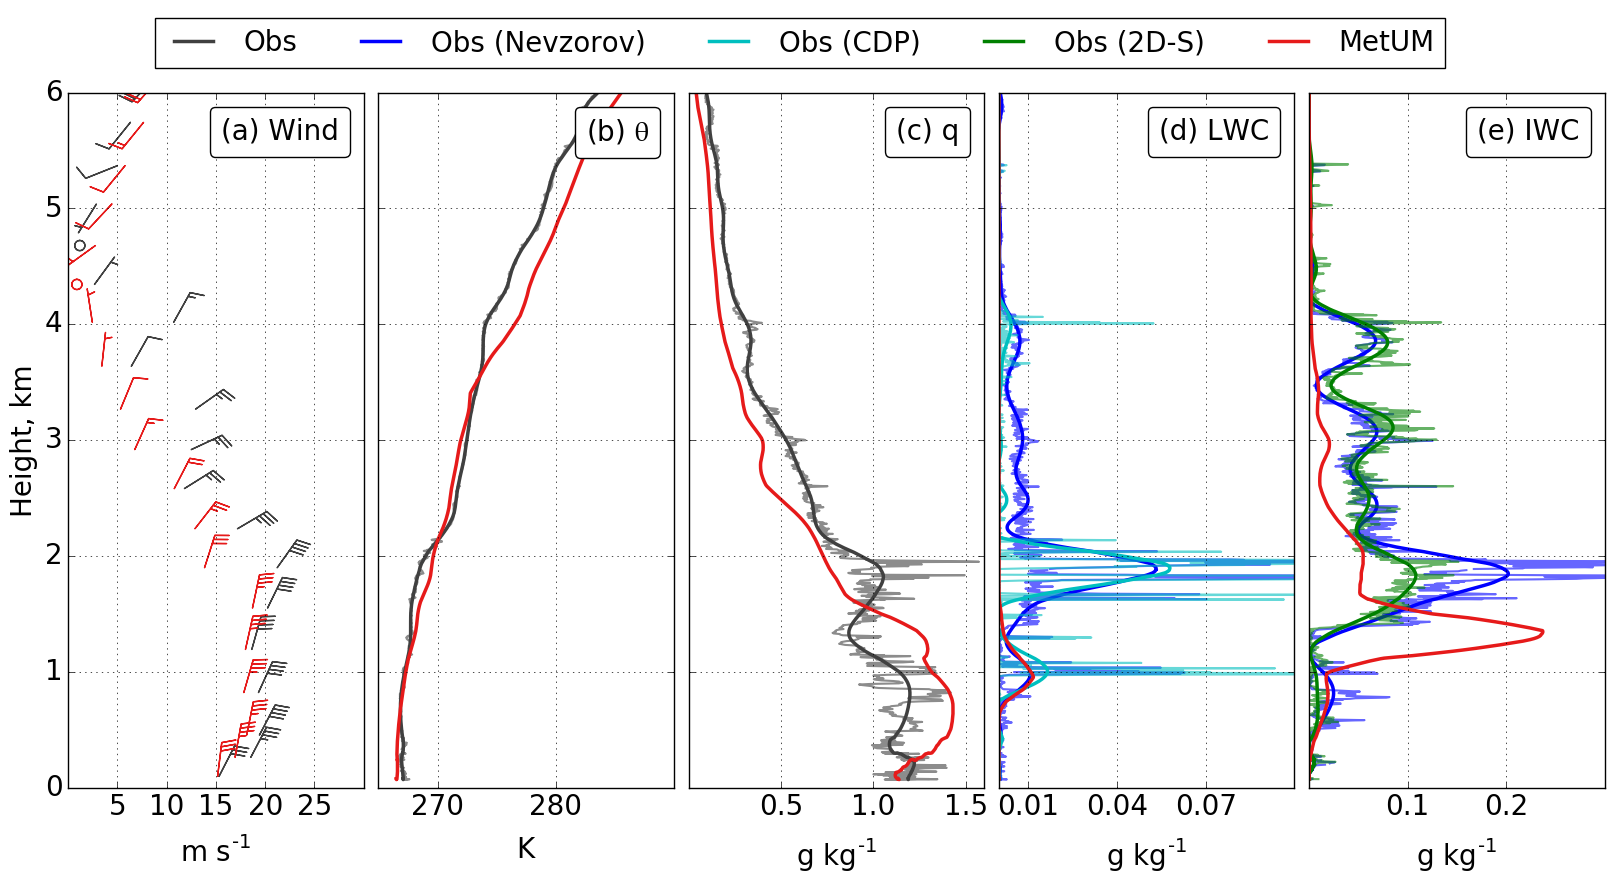

In [24]:
fig, axs = mympl.plot_n_zprofiles(vrbls2plot, fs=(16,8), legend=False)

axs[4].set_xlim(0,0.3)
axs[4].set_xticks(np.arange(0.1,0.21,0.1))
axs[3].set_xlim(0,0.1)
axs[3].set_xticks(np.arange(0.01,0.09,0.03))
axs[2].set_xlim(0,1.6)
axs[2].set_xticks(np.arange(0.5,1.7,0.5))
axs[0].set_xlim(0,30)
axs[0].set_xticks(np.arange(5,30,5))
axs[1].set_xlim(265,290)
axs[1].set_xticks(np.arange(270,290,10))

ttls = ['Wind', r'$\theta$', 'q', 'LWC', 'IWC']
for iax, lab, ttl in zip(axs, list(string.ascii_lowercase), ttls):
    iax.xaxis.set_label_coords(0.5,-0.07)
    txt = '({lab}) {ttl}'.format(lab=lab, ttl=ttl)
    at = AnchoredText(txt, prop=dict(size=20), frameon=True, loc=1)
    at.patch.set_boxstyle('round', pad=0., rounding_size=0.2)
    at.set_zorder(400)
    iax.add_artist(at)
[iax.set_title('') for iax in axs]
common_handles = [axs[1].get_legend_handles_labels()[0][0]] + axs[-2].get_legend_handles_labels()[0][:2] + axs[-1].get_legend_handles_labels()[0][1:]
common_labels = [axs[0].get_legend_handles_labels()[1][0]] + axs[-2].get_legend_handles_labels()[1][:2] + axs[-1].get_legend_handles_labels()[1][1:]
lgnd = fig.legend(common_handles, common_labels, fontsize=20, ncol=len(common_handles), loc=9, bbox_to_anchor=(0.5, 1.1))
# for label in lgnd.get_lines():
#     label.set_linewidth(2.5)

fig.tight_layout(pad=0.25)
fig.subplots_adjust(wspace=0.05)

fig.savefig(os.path.join('figures', 'aircraft_vs_um_{0}.{fmt}'.format(''.join(iseg[0].split()), fmt=fmt)), **svfigkw)

## Low-level legs

In [25]:
files_path= os.path.join(mypaths.extdir,
                         'UM',
                         'exp_results',
                         um_res.key,
                         fcst_init, 
                         'obs',
                         'processed',
                         'interpolated',
                         'interp_25_1200_hgt0-9999.nc')

In [26]:
f_interp = iris.load(files_path)

### Fig. 7: leg D-A

In [27]:
limname = 'hgt'
minlim = 0
maxlim = 350
tstep = 250 # stride lon/lat/time axis ticks

In [28]:
tt = np.where((minlim <= getattr(faam, limname).val) & (getattr(faam, limname).val <= maxlim)
            & (~np.isnan(faam.lon.val)) & (~np.isnan(faam.lat.val))
            & (faam.lat.val > 72.))[0]

In [29]:
mdt = mpl.dates.date2num(faam.time.val[tt])

### Time series

In [30]:
qq = np.where((minlim <= f_interp[0].coord('height').points) & (f_interp[0].coord('height').points <= maxlim))[0]
assert(len(qq)==len(tt))

In [31]:
interptime = f_interp[0].coord('time')
tm = interptime.units.num2date(interptime.points)

In [32]:
print(faam.time.val[tt][0],'\t', faam.time.val[tt][-1])
print(tm[qq][0],'\t', tm[qq][-1])

2013-03-26 12:35:24 	 2013-03-26 13:24:25
2013-03-26 12:35:24 	 2013-03-26 13:24:25


In [33]:
vrbls2plot = [] #  Variables to plot (Type: list of tuples of dictionaries)

# Wind barbs
s = 100 # plot every s-th barb
_temp = [dict(xax=mdt,
              data=(faam.hgt.val[tt],
                    faam.u.val[tt],
                    faam.v.val[tt],
                    s),
              label='Obs',
              apply_filt=True)]
u_um = f_interp_gps.extract_strict('interpolated_transformed_x_wind').data[qq]
v_um = f_interp_gps.extract_strict('interpolated_transformed_y_wind').data[qq]
_temp.append(dict(xax=mdt,
                  data=(faam.hgt.val[tt],
                        u_um,
                        v_um,
                        s),
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(plttype='barbs',
                  ttl='Wind barbs at aircraft flight altitude',
                  ylab='$m$'))
vrbls2plot.append(tuple(_temp))

# Wind speed
_temp = [dict(xax=mdt,
              data=faam.wspd.val[tt],
              label='Obs',
              apply_filt=True)]
u_um = f_interp_gps.extract_strict('interpolated_transformed_x_wind').data[qq]
v_um = f_interp_gps.extract_strict('interpolated_transformed_y_wind').data[qq]
um_ = met.uv2wspd(u_um, v_um)
_temp.append(dict(xax=mdt,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append( dict(ttl='Wind speed',
                   ylab='$m$ $s^{-1}$') )
vrbls2plot.append(tuple(_temp))

# Potential temperature
obs_ = met.calc_theta(faam.t_di.val[tt],
                      faam.pres.val[tt]*1e2)
_temp = [dict(xax=mdt,
              data=obs_,
              label='Obs',
              apply_filt=True)]
um_ = f_interp_gps.extract_strict('interpolated_air_potential_temperature').data[qq]
_temp.append(dict(xax=mdt,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Potential temperature',
                  ylab='$K$'))
vrbls2plot.append(tuple(_temp))

# Total specific humidity
_temp = [dict(xax=mdt,
              data=faam.twc_evap.val[tt],
              label='Obs',
              apply_filt=True)]
um_ = f_interp_gps.extract_strict('interpolated_TOTAL SPECIFIC HUMIDITY (qT)').data[qq]*1e3
_temp.append(dict(xax=mdt,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Total specific humidity',
                  ylab='$g$ $kg^{-1}$'))
vrbls2plot.append(tuple(_temp))

# LWC
_temp = []
_temp.append(dict(xax=mdt,
                  data=nevz_lwc_liq_mixr[tt-it1_nevz]*1e3,
                  label='Obs (Nevzorov)',
                  c='b',
                  lw=3,
                  apply_filt=True))
_temp.append(dict(xax=mdt,
                  data=cdp_lwc_mixr[tt]*1e3,
                  label='Obs (CDP)',
                  c='c',
                  apply_filt=True))
um_ = f_interp_gps.extract_strict('interpolated_mass_fraction_of_cloud_liquid_water_in_air').data[qq]*1e3
_temp.append(dict(xax=mdt,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Cloud liquid water mixing ratio',
                  ylab='$g$ $kg^{-1}$'))
vrbls2plot.append(tuple(_temp))

# FWC
_temp = []
_temp.append(dict(xax=mdt,
                  data=nevz_twc_ice_mixr[tt-it1_nevz]*1e3,
                  label='Obs (Nevzorov)',
                  c='b',
                  lw=3,
                  apply_filt=True))
_temp.append(dict(xax=mdt,
                  data=hi_2ds_mixr[tt-it1_2ds]*1e3+e_2ds_mixr[tt-it1_2ds]*1e3,
                  label='Obs (2D-S)',
                  c='g',
                  lw=3,
                  apply_filt=True))
um_ = f_interp_gps.extract_strict('interpolated_mass_fraction_of_cloud_ice_in_air').data[qq]*1e3
_temp.append(dict(xax=mdt,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Cloud frozen water mixing ratio',
                  ylab='$g$ $kg^{-1}$'))
vrbls2plot.append(tuple(_temp))

del _temp, um_

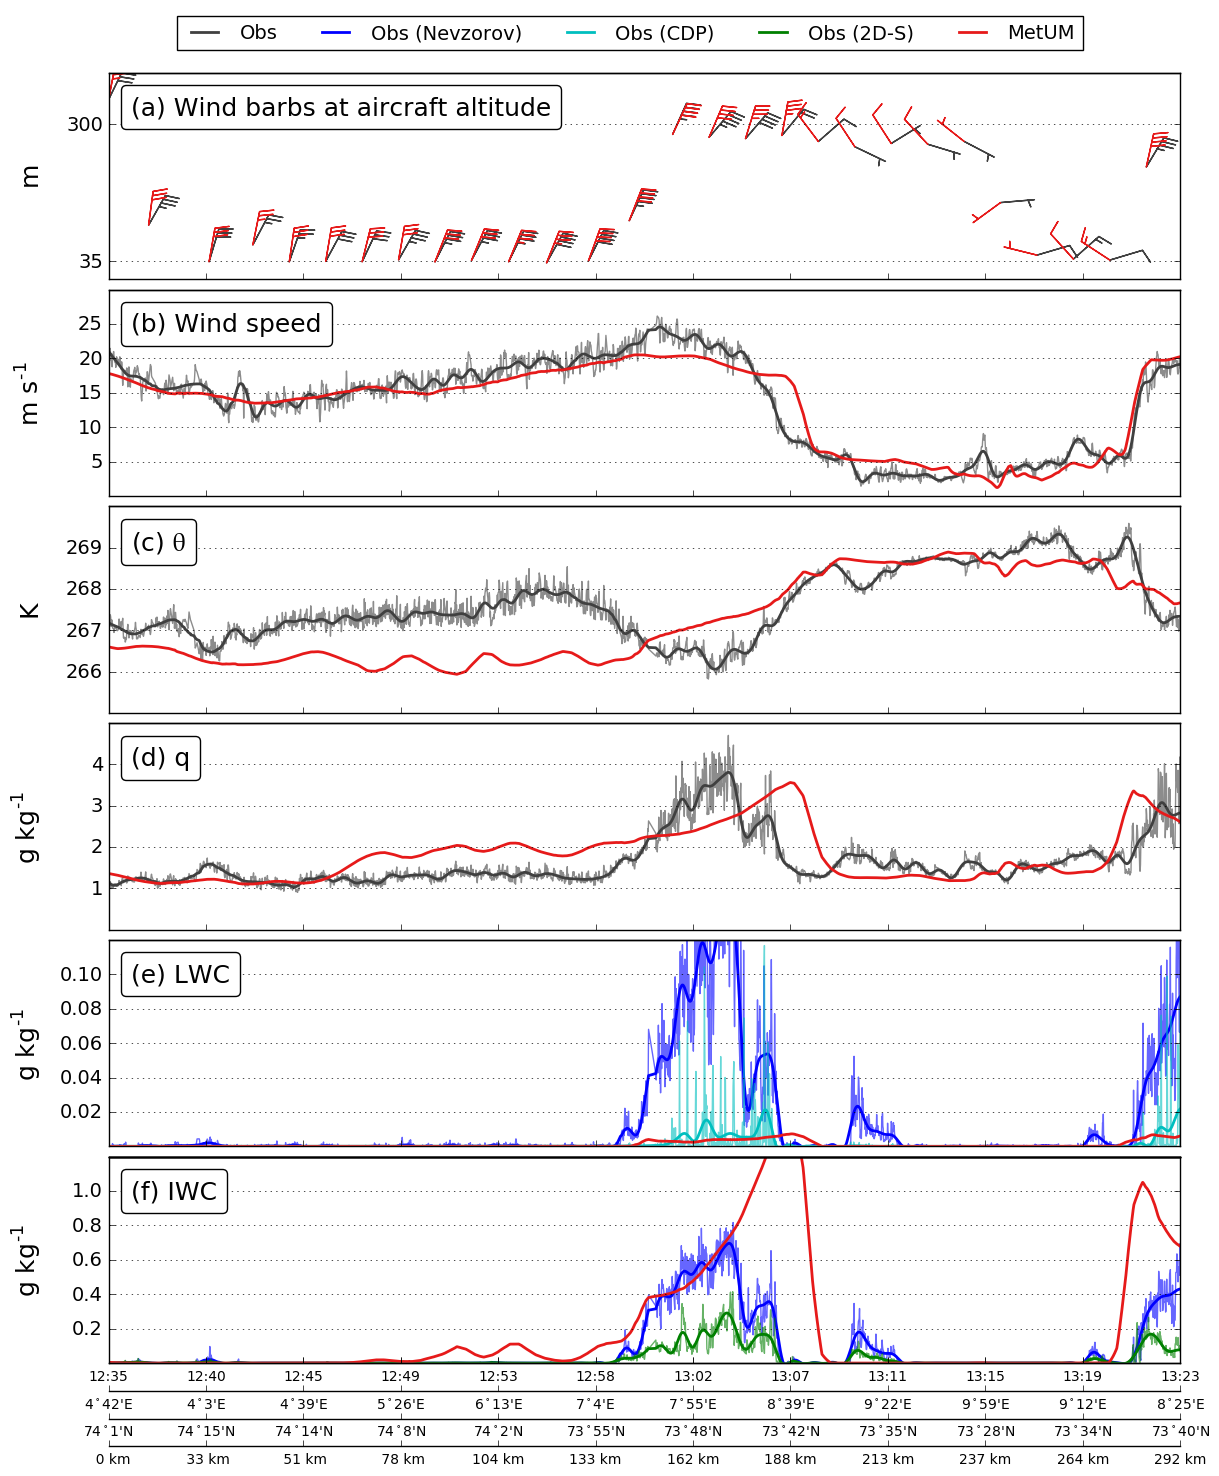

In [34]:
fig, axs = mympl.plot_n_tseries(vrbls2plot,
                                time=faam.time.val[tt],
                                lon=faam.lon.val[tt],
                                lat=faam.lat.val[tt],
                                llstep=tstep,
                                add_dist=True,
                                filt_keys=filt_keys,
                                fs=(12,14))

axs[0].set_yticks([35, 300])
axs[0].set_ylim(0, 400)
axs[1].set_yticks(np.arange(5,30,5))
axs[1].set_ylim(0,30)
axs[2].set_yticks(np.arange(266,270,1))
axs[2].set_ylim(265,270)
axs[3].set_yticks(np.arange(1,5,1))
axs[3].set_ylim(0,5)
axs[4].set_yticks(np.arange(0.02,0.12,0.02))
axs[4].set_ylim(0,0.12)
axs[5].set_ylim(0,1.2)
axs[5].set_yticks(np.arange(0.2,1.2,0.2))

[iax.set_title('') for iax in axs]
ttls = ['Wind barbs at aircraft altitude', 'Wind speed', r'$\theta$', 'q', 'LWC', 'IWC']
for iax, lab, ttl in zip(axs, list(string.ascii_lowercase), ttls):
    txt = '({lab}) {ttl}'.format(lab=lab, ttl=ttl)
    at = AnchoredText(txt, prop=dict(size=18), frameon=True, loc=2)
    at.patch.set_boxstyle('round', pad=0., rounding_size=0.2)
    at.set_zorder(400)
    iax.add_artist(at)

common_handles = [axs[1].get_legend_handles_labels()[0][0]] +\
                  axs[-2].get_legend_handles_labels()[0][:2] +\
                  axs[-1].get_legend_handles_labels()[0][1:]
common_labels = [axs[1].get_legend_handles_labels()[1][0]] +\
                 axs[-2].get_legend_handles_labels()[1][:2] +\
                 axs[-1].get_legend_handles_labels()[1][1:]
lgnd = fig.legend(common_handles,
                  common_labels, 
                  fontsize=14, 
                  ncol=len(common_handles), 
                  loc=9, 
                  bbox_to_anchor=(0.525, 1.05))

fig.tight_layout(pad=0.25)
fig.subplots_adjust(hspace=0.05)
fig.savefig(os.path.join('figures',
                         'aircraft_vs_um_timeseries_{zzbottom}-{zztop}m.{fmt}'.format(zzbottom=minlim,
                                                                                      zztop=maxlim,
                                                                                      fmt=fmt)),
            **svfigkw)

### Fig. 11: 860m altitude

In [35]:
limname = 'hgt'
minlim = 850
maxlim = 950
lonlim = 7
tstep = 100 # stride lon/lat/time axis ticks

In [36]:
tt = np.where((minlim <= getattr(faam, limname).val) & (getattr(faam, limname).val <= maxlim)
            & (~np.isnan(faam.lon.val)) & (~np.isnan(faam.lat.val))
            & (faam.lat.val > 72.) & (faam.lon.val > lonlim))[0]

In [37]:
mdt = mpl.dates.date2num(faam.time.val[tt])

In [38]:
qq = np.where((minlim <= f_interp[0].coord('height').points) & (f_interp[0].coord('height').points <= maxlim)\
             & (f_interp[0].coord('longitude').points > lonlim))[0]
assert(len(qq)==len(tt))

In [39]:
interptime = f_interp[0].coord('time')
tm = interptime.units.num2date(interptime.points)

In [40]:
print(faam.time.val[tt][0],'\t', faam.time.val[tt][-1])
print(tm[qq][0],'\t', tm[qq][-1])

2013-03-26 13:26:10 	 2013-03-26 13:42:16
2013-03-26 13:26:10 	 2013-03-26 13:42:16


In [41]:
vrbls2plot = [] #  Variables to plot (Type: list of tuples of dictionaries)

# Wind barbs
s = 100 # plot every s-th barb
_temp = [dict(xax=mdt,
              data=(faam.hgt.val[tt],
                    faam.u.val[tt],
                    faam.v.val[tt],
                    s),
              label='Obs',
              apply_filt=True)]
u_um = f_interp_gps.extract_strict('interpolated_transformed_x_wind').data[qq]
v_um = f_interp_gps.extract_strict('interpolated_transformed_y_wind').data[qq]
_temp.append(dict(xax=mdt,
                  data=(faam.hgt.val[tt],
                        u_um,
                        v_um,
                        s),
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(plttype='barbs',
                  ttl='Wind barbs at aircraft flight altitude',
                  ylab='$m$'))
vrbls2plot.append(tuple(_temp))

# Wind speed
_temp = [dict(xax=mdt,
              data=faam.wspd.val[tt],
              label='Obs',
              apply_filt=True)]
u_um = f_interp_gps.extract_strict('interpolated_transformed_x_wind').data[qq]
v_um = f_interp_gps.extract_strict('interpolated_transformed_y_wind').data[qq]
um_ = met.uv2wspd(u_um, v_um)
_temp.append(dict(xax=mdt,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append( dict(ttl='Wind speed',
                   ylab='$m$ $s^{-1}$') )
vrbls2plot.append(tuple(_temp))

# Potential temperature
obs_ = met.calc_theta(faam.t_di.val[tt],
                      faam.pres.val[tt]*1e2)
_temp = [dict(xax=mdt,
              data=obs_,
              label='Obs',
              apply_filt=True)]
um_ = f_interp_gps.extract_strict('interpolated_air_potential_temperature').data[qq]
_temp.append(dict(xax=mdt,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Potential temperature',
                  ylab='$K$'))
vrbls2plot.append(tuple(_temp))

# Total specific humidity
_temp = [dict(xax=mdt,
              data=faam.twc_evap.val[tt],
              label='Obs',
              apply_filt=True)]
um_ = f_interp_gps.extract_strict('interpolated_TOTAL SPECIFIC HUMIDITY (qT)').data[qq]*1e3
_temp.append(dict(xax=mdt,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Total specific humidity',
                  ylab='$g$ $kg^{-1}$'))
vrbls2plot.append(tuple(_temp))

# LWC
_temp = []
_temp.append(dict(xax=mdt,
                  data=nevz_lwc_liq_mixr[tt-it1_nevz]*1e3,
                  label='Obs (Nevzorov)',
                  c='b',
                  lw=3,
                  apply_filt=True))
_temp.append(dict(xax=mdt,
                  data=cdp_lwc_mixr[tt]*1e3,
                  label='Obs (CDP)',
                  c='c',
                  apply_filt=True))
um_ = f_interp_gps.extract_strict('interpolated_mass_fraction_of_cloud_liquid_water_in_air').data[qq]*1e3
_temp.append(dict(xax=mdt,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Cloud liquid water mixing ratio',
                  ylab='$g$ $kg^{-1}$'))
vrbls2plot.append(tuple(_temp))

# FWC
_temp = []
_temp.append(dict(xax=mdt,
                  data=nevz_twc_ice_mixr[tt-it1_nevz]*1e3,
                  label='Obs (Nevzorov)',
                  c='b',
                  lw=3,
                  apply_filt=True))
_temp.append(dict(xax=mdt,
                  data=hi_2ds_mixr[tt-it1_2ds]*1e3+e_2ds_mixr[tt-it1_2ds]*1e3,
                  label='Obs (2D-S)',
                  c='g',
                  lw=3,
                  apply_filt=True))
um_ = f_interp_gps.extract_strict('interpolated_mass_fraction_of_cloud_ice_in_air').data[qq]*1e3
_temp.append(dict(xax=mdt,
                  data=um_,
                  label=um_label,
                  c=pp.cvec[1]))
_temp.append(dict(ttl='Cloud frozen water mixing ratio',
                  ylab='$g$ $kg^{-1}$'))
vrbls2plot.append(tuple(_temp))

del _temp, um_

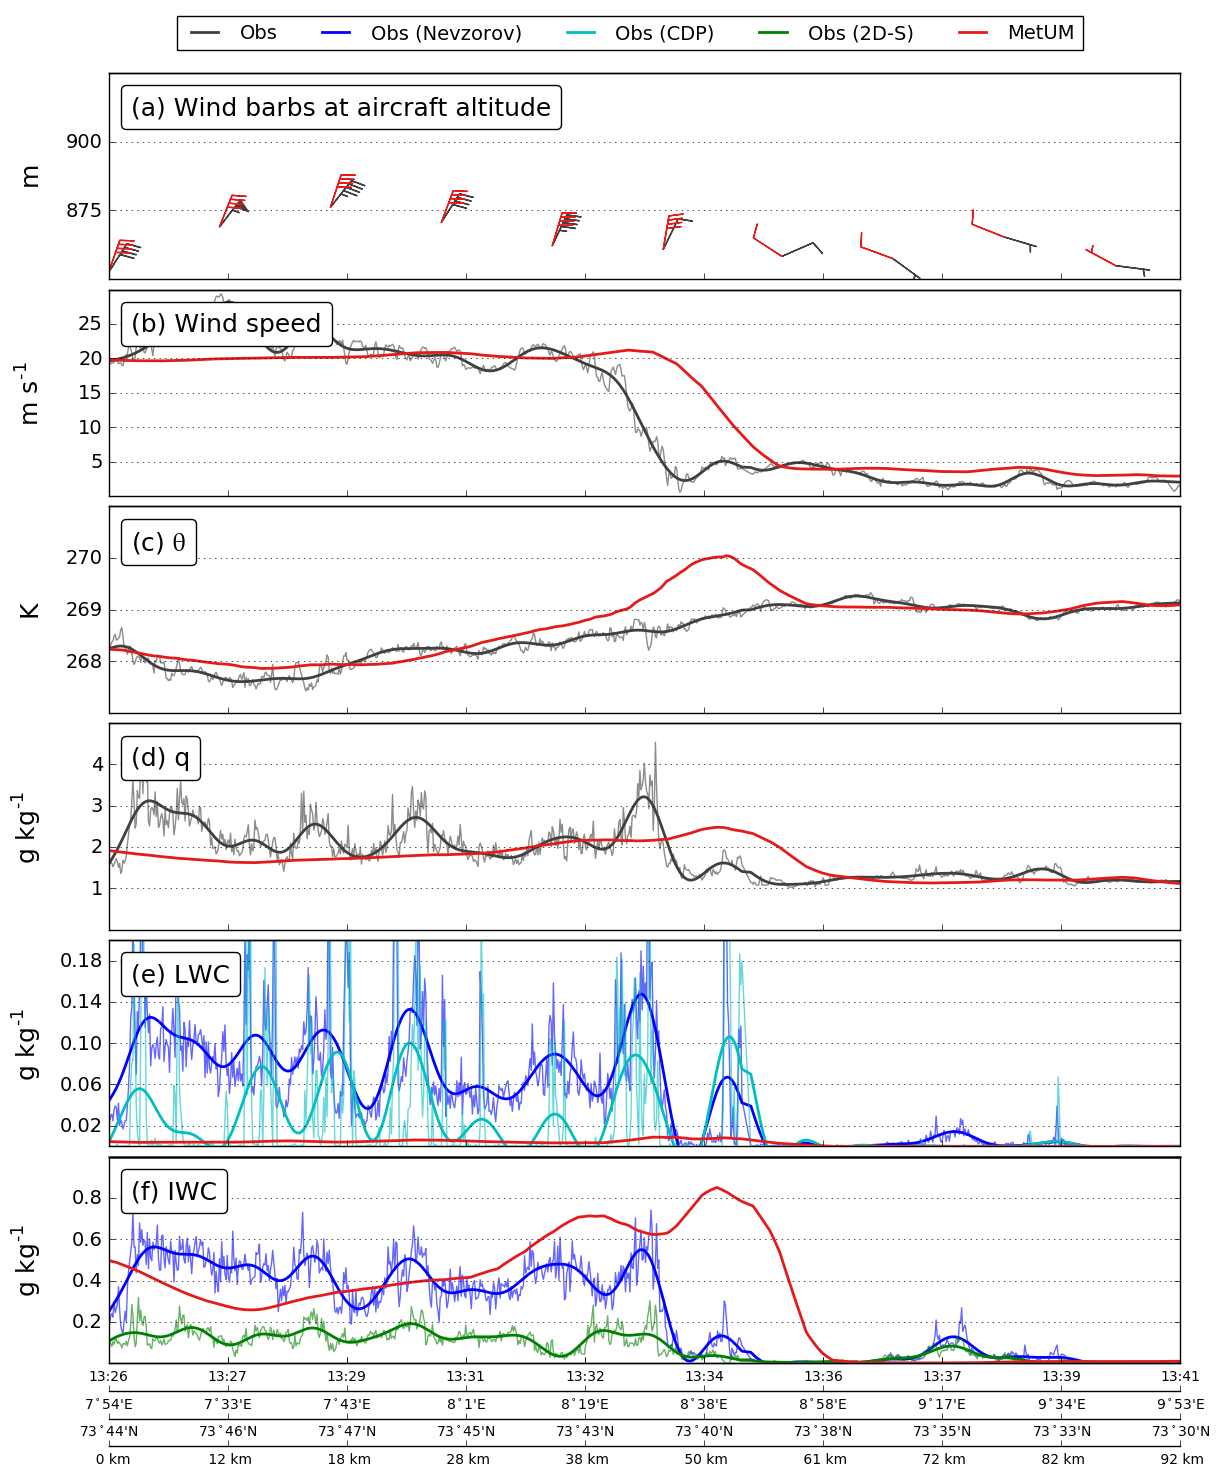

In [42]:
fig, axs = mympl.plot_n_tseries(vrbls2plot,
                                time=faam.time.val[tt],
                                lon=faam.lon.val[tt],
                                lat=faam.lat.val[tt],
                                llstep=tstep,
                                add_dist=True,
                                filt_keys=filt_keys,
                                fs=(12,14))
axs[0].set_yticks([875, 900])
axs[0].set_ylim(850, 925)
axs[1].set_yticks(np.arange(5,30,5))
axs[1].set_ylim(0,30)
axs[2].set_yticks(np.arange(268,271,1))
axs[2].set_ylim(267,271)
axs[3].set_yticks(np.arange(1,5,1))
axs[3].set_ylim(0,5)
axs[4].set_yticks(np.arange(0.02,0.2,0.04))
axs[4].set_ylim(0,0.2)
axs[5].set_ylim(0,1)
axs[5].set_yticks(np.arange(0.2,1.,0.2))

[iax.set_title('') for iax in axs]
ttls = ['Wind barbs at aircraft altitude', 'Wind speed', r'$\theta$', 'q', 'LWC', 'IWC']
for iax, lab, ttl in zip(axs, list(string.ascii_lowercase), ttls):
    txt = '({lab}) {ttl}'.format(lab=lab, ttl=ttl)
    at = AnchoredText(txt, prop=dict(size=18), frameon=True, loc=2)
    at.patch.set_boxstyle('round', pad=0., rounding_size=0.2)
    at.set_zorder(400)
    iax.add_artist(at)

common_handles = [axs[1].get_legend_handles_labels()[0][0]] +\
                  axs[-2].get_legend_handles_labels()[0][:2] +\
                  axs[-1].get_legend_handles_labels()[0][1:]
common_labels = [axs[1].get_legend_handles_labels()[1][0]] +\
                 axs[-2].get_legend_handles_labels()[1][:2] +\
                 axs[-1].get_legend_handles_labels()[1][1:]
lgnd = fig.legend(common_handles,
                  common_labels, 
                  fontsize=14, 
                  ncol=len(common_handles), 
                  loc=9, 
                  bbox_to_anchor=(0.525, 1.05))

fig.tight_layout(pad=0.25)
fig.subplots_adjust(hspace=0.05)
fig.savefig(os.path.join('figures',
                         'aircraft_vs_um_timeseries_{zzbottom}-{zztop}m.{fmt}'.format(zzbottom=minlim,
                                                                                      zztop=maxlim,
                                                                                      fmt=fmt)),
            **svfigkw)